# Game of Life

In this notebook we model the game of life as an agent based model using AlgebraicRewriting.

We start with some imports:

In [1]:

using Pkg; Pkg.activate("..")
using AlgebraicRewriting
using Catlab, Catlab.Graphs, Catlab.CategoricalAlgebra, Catlab.Theories
import Catlab.Graphics: to_graphviz
using Catlab.Graphics.Graphviz: Attributes, Statement, Node, Edge, Digraph
using PrettyTables
using Luxor


  Activating project at `~/code/AlgebraicRewriting.jl/docs`
[ Info: Precompiling AlgebraicRewriting [725a01d3-f174-5bbd-84e1-b9417bad95d9]
[ Info: Precompiling AlgebraicRewritingLuxorExt [37cb9f14-6fbc-53ad-b441-168fc6dcbed6]


# Schema

Core to the AlgebraicJulia modeling paradigm is picking a **schema** to represent the datatype one is working with. We will represent the state of the world as a database with the following schema:

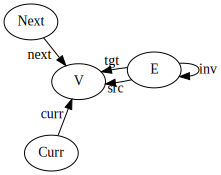

In [2]:

"""
`curr` and `next` pick out subsets of V which are marked as currently alive or 
to be alive in the next timestep.
"""
@present SchLife <: SchSymmetricGraph begin 
  (Curr, Next)::Ob 
  curr::Hom(Curr,V)
  next::Hom(Next,V)
end

to_graphviz(SchLife)

This says that there is a *symmetric graph* and that a subset of the vertices are distinguished as currently alive. (note, the map *into* `V` from `Curr` is mathematically tantamount to a map *out* of `V` into a `Bool` attribute - both distinguish a subset of `V`).

Furthermore, it is helpful computationally to be able to simultaneously pick out a subset of vertices which will be alive in the *next* timestep. This graph is more general than the usual grid-based approach to the game of life, but we can extend the schema with coordinate information with the following code: 

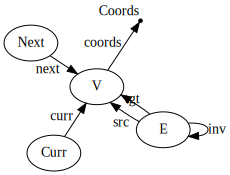

In [3]:
@present SchLifeCoords <: SchLife begin 
  Coords::AttrType 
  coords::Attr(V, Coords)
end
to_graphviz(SchLifeCoords)

We then create data types based off of these schemas and define a functor which will allow us to migrate simulators on the coordinate-less schema into the schema with coordinates (since the coordinates do not play any semantic role, given there is already a connectivity graph). 

In [4]:
@acset_type Life(SchLife) <: AbstractSymmetricGraph
@acset_type AbsLifeCoords(SchLifeCoords) <: AbstractSymmetricGraph
const LifeCoords = AbsLifeCoords{Tuple{Int,Int}}

O, H = [Dict(x=>x for x in Symbol.(generators(SchLife,x))) for x in [:Ob,:Hom]]
F = Migrate(O, H, LifeCoords; delta=false); # Migrate in forward direction
F⁻¹(X::LifeCoords) = migrate(Life, X, O, H); # Migrate in reverse direction 
F⁻¹(f::ACSetTransformation) = ACSetTransformation(F⁻¹(dom(f)), F⁻¹(codom(f)); V=collect(f[:V]));

# Helper functions
Some helper functions will make it easy to succinctly express the model as well as visually see what is going on.
## Visualization

In [5]:
function view_life(f::ACSetTransformation, pth=tempname())
  v = collect(f[:V])
  view_life(codom(f), pth; star=isempty(v) ? nothing : only(v))
end
function view_life(X::Life, pth=tempname(); star=nothing)
  pg = PropertyGraph{Any}(; prog = "neato", graph = Dict(),
  node = Dict(:shape => "circle", :style=>"filled", :margin => "0"), 
  edge = Dict(:dir=>"none",:minlen=>"1"))
  add_vertices!(pg, nparts(X,:V))
  for v in vertices(X)
    set_vprop!(pg, v, :fillcolor, isempty(incident(X,v,:curr)) ? "red" : "green")
    if !isempty(incident(X,v,:next))
      set_vprop!(pg, v, :penwidth, "4.0")
    end
    set_vprop!(pg, v, :label, star == v ? "*" : "")
  end
  for e in filter(e->X[e,:inv] > e, edges(X))
    add_edge!(pg, X[e,:src], X[e,:tgt])
  end
  G = to_graphviz(pg)
  open(pth, "w") do io 
    show(io,"image/svg+xml",G) 
  end
  G
end
function view_life(X::LifeCoords, pth=tempname(); star=nothing)
  n = Int(sqrt(nparts(X,:V)))
  coords = Dict([(i,j)=>findfirst(==((i,j)), X[:coords]) 
                 for (i,j) in Iterators.product(1:n,1:n)])
  mat = pretty_table(String, reduce(hcat,map(1:n) do i 
    map(1:n) do j 
      c, x = [!isempty(incident(X, coords[(i,j)],x)) for x in [:curr, :next]]
      res = c ? (x ? "O" : "o") : (x ? "X" : "x")
      return res * ((star == coords[(i,j)]) ? "." : "")
    end
  end); show_header=false, tf=tf_markdown)
  open(pth, "w") do io write(io, mat) end
  return mat
end;

## Constructing ACSets / maps between them 

In [6]:
Next() = @acset Life begin V=1; Next=1; next=1 end
Curr() = @acset Life begin V=1; Curr=1; curr=1 end
to_next() = homomorphism(Life(1), Next())
to_curr() = homomorphism(Life(1), Curr())

"""Construct a cell connected to n living neighbors"""
function living_neighbors(n::Int; alive=false)
  X = Life(1)
  if alive add_part!(X, :Curr, curr=1) end
  for _ in 1:n
    v = add_part!(X, :V)
    add_part!(X,:Curr,curr=v)
    add_edge!(X, v, 1)
    end
  return X
end;

When something is marked as currently alive, it is filled in green.

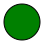

In [7]:
view_life(Curr())

When something has been marked as to-be-alive in the next timestep, it has a thick border: 

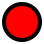

In [8]:
view_life(Next())

Therefore, something that is both alive and to-be-alive next will look like this:

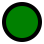

In [9]:
view_life(@acset Life begin V=1; Next=1; Curr=1; next=1; curr=1 end)

`living_neighbors` is helpful for rules that concern the # of living neighbors.

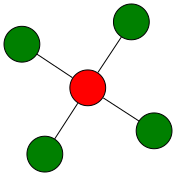

In [10]:
view_life(living_neighbors(4))

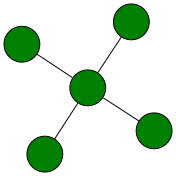

In [11]:
view_life(living_neighbors(4; alive=true))

## Initialization of LifeCoords

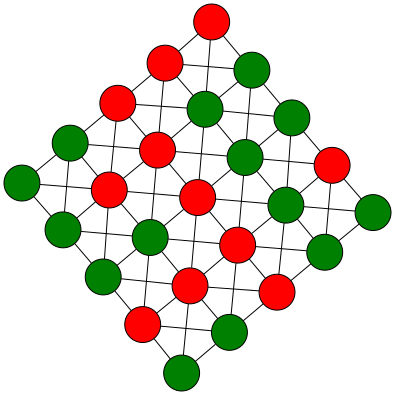

In [12]:
function make_grid(curr::AbstractMatrix, next=nothing)
  n, m = size(curr)
  n == m || error("Must be square")
  X, coords = LifeCoords(), Dict()
  for i in 1:n
    for j in 1:n
      coords[i=>j] = add_vertex!(X; coords=(i,j))
      if Bool(curr[i,j]) add_part!(X, :Curr, curr=coords[i=>j]) end
      if !isnothing(next) && Bool(next[i,j]) 
        add_part!(X, :Curr, curr=coords[i=>j]) 
      end
    end
  end
  for i in 1:n
    for j in 1:n
      if i < n add_edge!(X, coords[i=>j], coords[i+1=>j]) end 
      if j < n add_edge!(X,coords[i=>j], coords[i=>j+1]) end
      if i < n && j < n add_edge!(X,coords[i=>j], coords[i+1=>j+1]) end
      if i < n && j > 1 add_edge!(X,coords[i=>j], coords[i+1=>j-1]) end
    end
  end
  return X 
end
make_grid(n::Int, random=false) = make_grid((random ? rand : zeros)(Bool, (n,n)))
view_life(make_grid(5, true) |> F⁻¹)

We default to graphviz to visualize states of the world that do not have coordinate information. When we do have coordinate information, we can visualize with ASCII, but we'll opt to not use that in this notebook.

In [13]:
make_grid(5, true) |> view_life |> println

| o | x | o | o | x |
| o | x | o | o | x |
| o | x | o | o | x |
| o | o | x | o | x |
| x | x | o | o | o |



# Rules 
The core of an ABM is the rewrite rules which define the possible transitions. 

Our first rule, `Birth` encodes: a dead cell becomes alive iff it has exactly 3 living neighbors.


In [14]:
BirthP1 = living_neighbors(3) # must have 3 neighbors
BirthN1 = living_neighbors(4) # forbid the cell to have 4 neighbors
BirthN2 = Curr() # forbid the cell to be alive (i.e. it's currently dead)
BP1, BN1, BN2 = homomorphism.(Ref(Life(1)), [BirthP1, BirthN1, BirthN2])
bac = [AppCond(BP1; monic=true), AppCond.([BN1,BN2], false; monic=true)...]
Birth = Rule(id(Life(1)), to_next(); ac=bac);

Let's unpack this a bit. The essence of a rewrite rule is a span `L <- I -> R`, with the pattern `L` being what we're looking for and the replacement `R` being what we replace with. If we look at the `L` of `Birth`, we see:

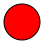

In [15]:
Birth |> left |> codom |> view_life

Now let's look at what this gets replaced with:

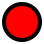

In [16]:
Birth |> right |> codom |> view_life

Therefore, the impact of applying this rule is to add a vertex to the subset of vertices which are to-be-alive in the next timestep. However, we want to say more about when it is valid to apply the rule. We can do this by attaching positive and negative **application conditions** to the rule. Our positive application condition is that there must be at least three living neighbors:

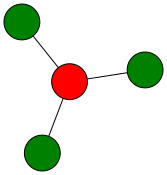

In [17]:
BirthP1 |> view_life

A negative application is that there cannot be four living neighbors:

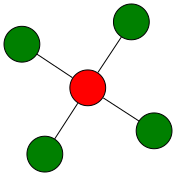

In [18]:
BirthN1 |> view_life

We also want this rule to be applicable to only presently dead vertices. Our encoding of dead vs live vertices has the quirk that a map from a vertex could go to a living or a dead vertex. So to prevent our rule from applying to vertices which are already alive, we need another negative application to forbid this!

Our next rule `Persist` encodes:  a living cell stays alive iff it has 2 or 3 living neighbors.

In [19]:
PersistR = @acset Life begin V=1; Curr=1; Next=1; curr=1; next=1 end
PersistP1 = living_neighbors(2; alive=true)
PersistN1 = living_neighbors(4; alive=true)
DR, DP1, DN1 = homomorphism.(Ref(Curr()), [PersistR, PersistP1, PersistN1])
pac = [AppCond(DP1; monic=true), AppCond(DN1, false; monic=true)]
Persist = Rule(id(Curr()), DR; ac=pac);

Those are the core dynamics of the Game of Life, but at the end of each timestep our implementation needs to handle updating what is currently alive with what was marked as to-be-alive. This is handled with three simple rules which can be applied (in sequence) to each vertex:

In [20]:
ClearCurr = Rule(to_curr(), id(Life(1))) # Remove "Curr" status
CopyNext =  Rule(to_next(), to_curr())   # Copy "Next" to "Curr"
ClearNext = Rule(to_next(), id(Life(1))) # Remove "Next" status

rules = [:Birth=>Birth, :Persist=>Persist, :ClearCurr=>ClearCurr,
         :ClearNext=>ClearNext, :CopyNext=>CopyNext];

# Schedule

Now that our basic dynamic building blocks, the rewrite rules, have been established, we lastly need to string them together into a simulation. We first create "boxes" for the rewrite rules which will be put into a wiring diagram:

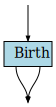

In [21]:
rBirth, rPersist, rClearCurr, rClearNext, rCopyNext = 
  [tryrule(RuleApp(n, r, Life(1))) for (n,r) in rules] 

view_sched(rBirth)

When the world-state comes in along the wire from the top, it enters the rewrite box which attempts to fire the rewrite rule. Note that, although a rewrite rule generally has two possible outputs (depending on whether or not the rule was successfully applied), for this simulation we won't distinguish these two cases, expressed by the merging of the output wires into a single control flow. This makes it very straightforward to compose the rules together in sequence:

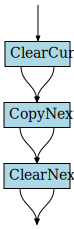

In [22]:
view_sched(rClearCurr ⋅ rCopyNext ⋅ rClearNext)

A subtle detail when creating the `RuleApp` rewrite rule boxes was the third argument (after the name and the rule itself) which was the *interface* of the rule. By putting `Life(1)` (which is just a vertex), we communicate that the rewrite rule is relative to a distinguished vertex. This allows us to have control over *which* vertex we are applying the rewrite rule. Yellow `Query` boxes have the semantics of executing a subroutine for each agent of a particular shape, so the following schedule will apply `Birth` and `Persist` to each vertex in order to systematically update `Next` for the entire world state.

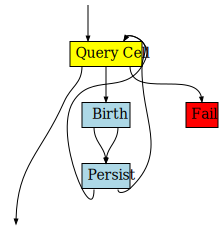

In [23]:
update_next = agent(rBirth ⋅ rPersist, Life(1); n=:Cell)
view_sched(update_next)

One enters a `Query` box in the first (leftmost) port, exits the second output port for each subobject (re-entering through the second input) - at the very end we exit through the first output port. (The third output port is only needed in rare circumstances, we don't treat it as a possibility by attaching a `Fail` block to that path).

Our final schedule is a `for` loop wrapping two sequences of a rewrite rules which are executed for every vertex: the first sequence above (which assumes that `Curr` is correct and computes `Next`) and a second sequence (which assumes `Next` is correct and uses it to overwrite `Curr`).

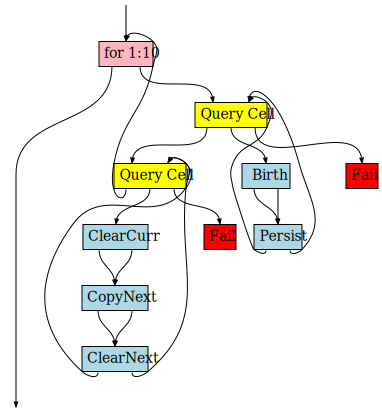

In [24]:
next_step = agent(compose(rClearCurr, rCopyNext, rClearNext), Life(1); n=:Cell)
life(n::Int) = for_schedule(update_next ⋅ next_step, n) |> F
view_sched(life(10))

# Example
We apply the schedule (doing a single timestep) to an input and plot the trajectory.

In [25]:
G = make_grid([1 0 1 0 1; 0 1 0 1 0 ; 0 1 0 1 0 ; 1 0 1 0 1; 1 0 1 0 1])
res, = apply_schedule(life(1), G; steps=1000);
view_traj(life(1), res, ((f,s)->view_life(F⁻¹(f),s)); agent=true);

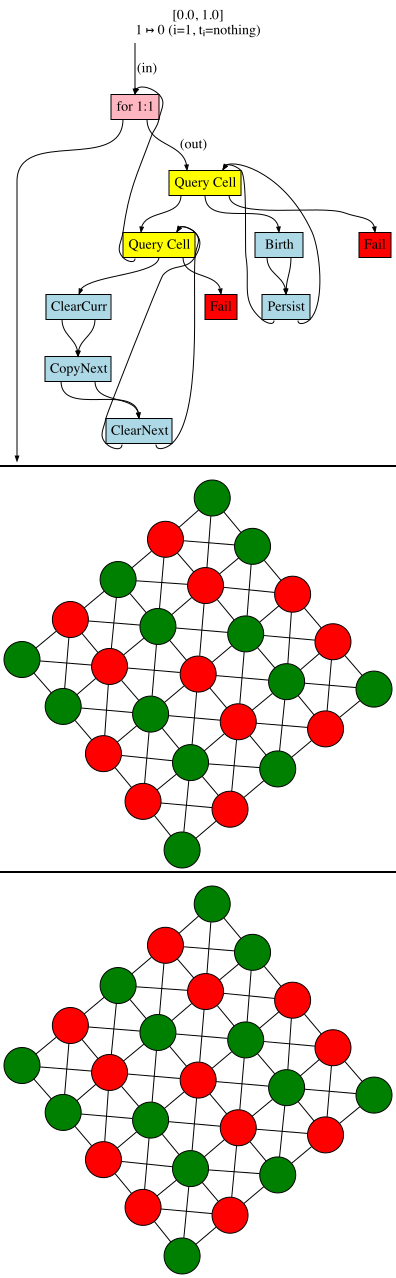

In [26]:
readpng("traj/1.png") # start by going out the right port of the for box

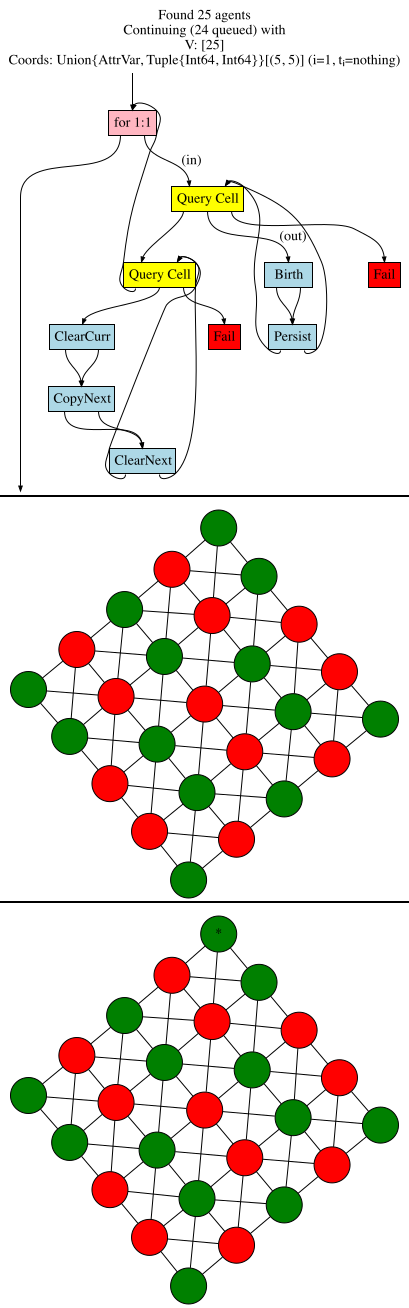

In [27]:
readpng("traj/2.png") # pick our first "agent"

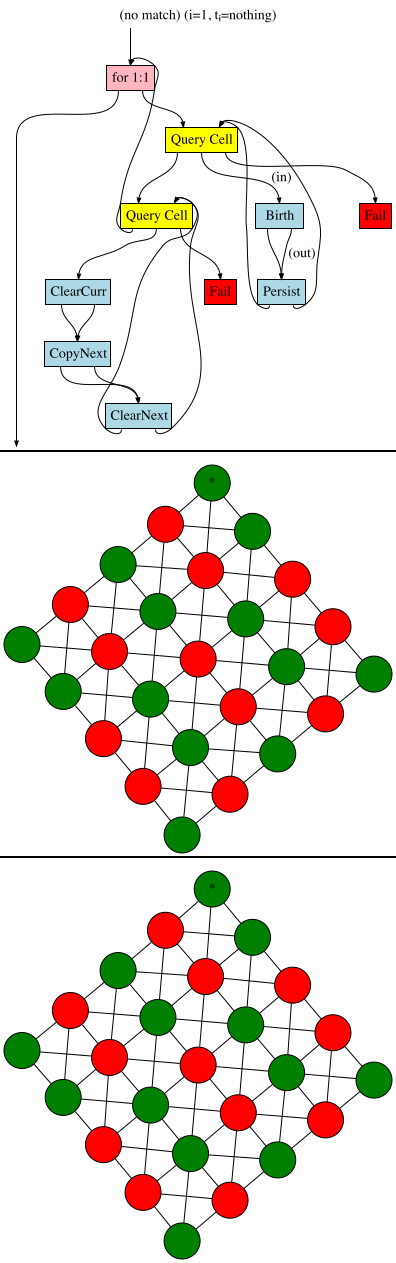

In [28]:
readpng("traj/3.png") # Birth doesn't apply b/c it's alive

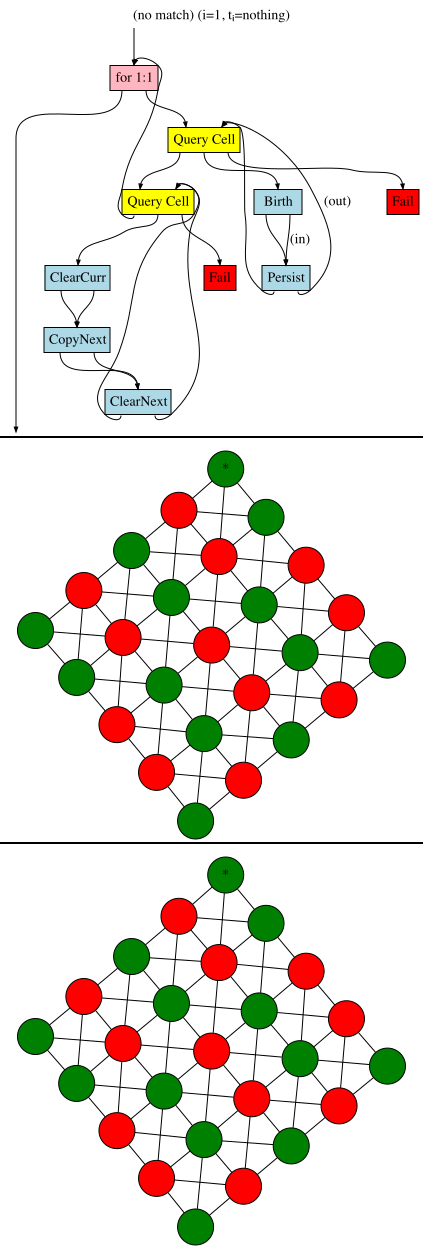

In [29]:
readpng("traj/4.png") # Persist doesn't apply b/c only one living neighbor

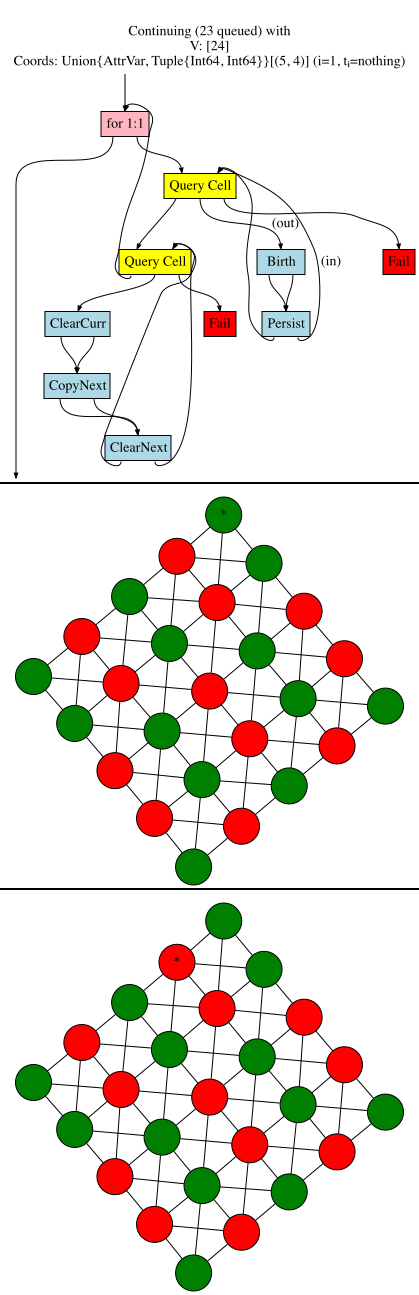

In [30]:
readpng("traj/5.png") # Switch to next agent

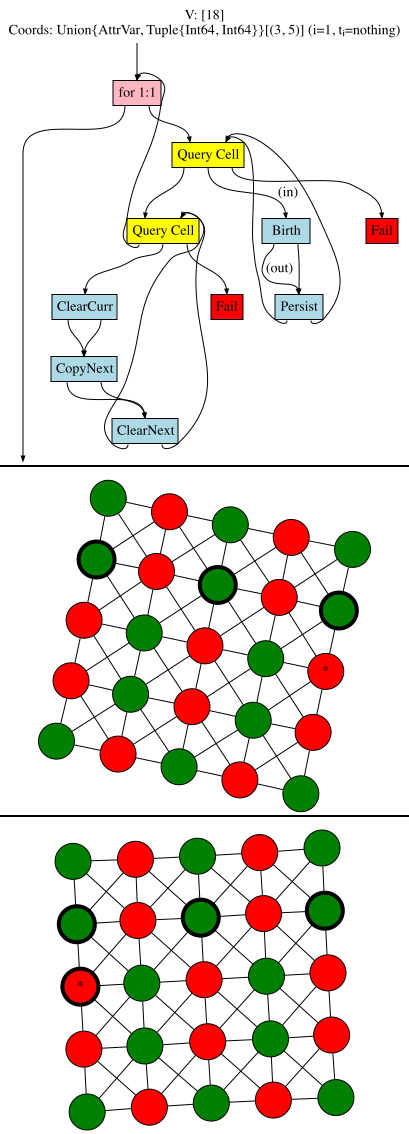

In [31]:
readpng("traj/33.png") # An example of Birth being applied

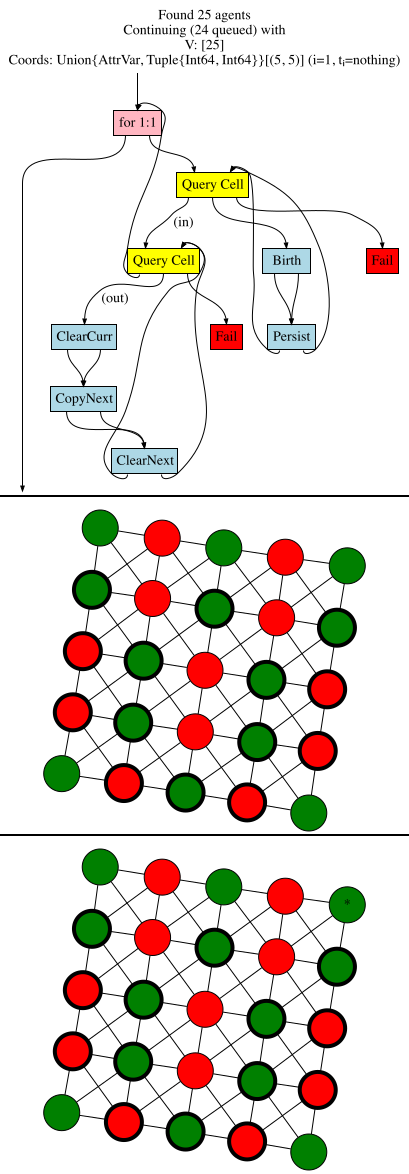

In [32]:
readpng("traj/78.png") # We have updated all the agents, 14/25 will be alive next timestep

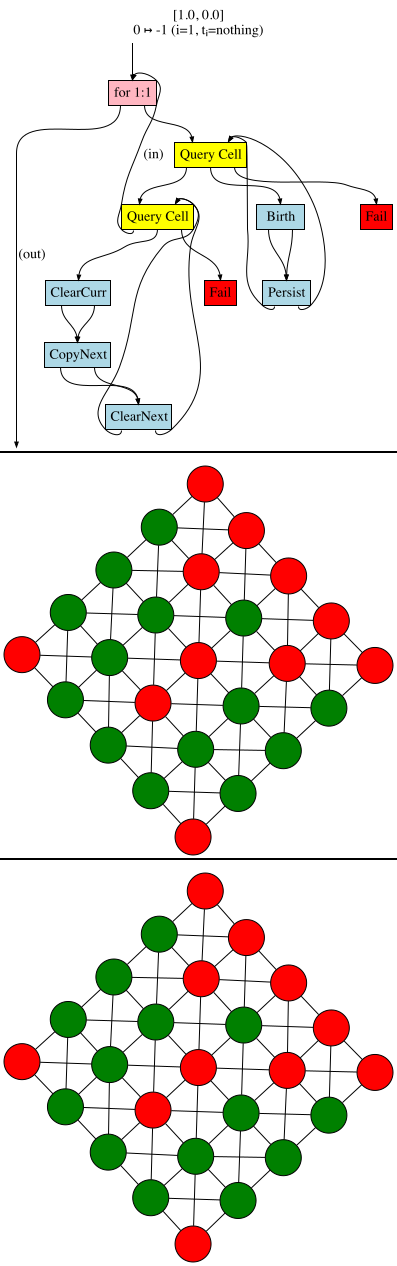

In [33]:
readpng("traj/179.png") # final result. Exit b/c for loop counter is done.